## Deconvolution

For a proper analysis, we need:
  * A proper rescaling of the electron energy scale. Right now, it's just based on the half max point.
  * A better signal model than only a Gaussian spectrum.
  * Background subtraction
  * Acceptance estimate (Current method: a guess based on how the spectra look).

### Load the spectrum from previous notebooks

In [1]:
# Load the NG data and the response function and dump output into variables
from IPython.utils import io
with io.capture_output() as output_03:
    %run '03_2d_spectra.ipynb'
with io.capture_output() as output_05:
    %run '05_response function.ipynb'
with io.capture_output() as output_10:
    %run '10_read_andreas_result.ipynb'

In [2]:
import time
print('Current CPU time: %d seconds' % time.clock())

Current CPU time: 117 seconds


In [3]:
# You can execute one of these lines if you want to view the output of these scripts
#output_03()
#output_05()

### Define functions

In [4]:
def get_neutron_spectrum(mu, sigma):
    '''
    Get the smeared version of the response for an original neutron spectrum that is Gaussian in energy.
    Mu and sigma in MeV please.
    Requires globally defined 'neutron_energies', 'electron_energies' and 'response'
    '''
    # The parameter 'electron_energies'  comes from the presupplied response function 
    smeared_response = np.zeros(len(electron_energies))
    
    # Loop over all neutron energy bins expect for last one
    for i in range(len(neutron_energies) - 1):
        # Current neutron energy
        neutron_energy = neutron_energies[i]
        # Current bin width
        bin_width = neutron_energies[i+1] - neutron_energies[i]
        # Current amplitude in the neutron spectrum
        ampl = gaussian(neutron_energy, mu, sigma)
        # Full response for this neutron energy bin
        smeared_response += bin_width*ampl*response[i]
    return smeared_response

def get_neutron_spectrum_interpolated(energy_list, a, mu, sigma):
    '''
    Interpolate the function that we get from 'get_neutron_spectrum'  to fit 'energy_list'
    '''
    smeared_response = get_neutron_spectrum(mu, sigma)
    return a * np.interp(energy_list, 1000*electron_energies, smeared_response)

def get_neutron_spectrum_interpolated_2(energy_list, a1, mu1, sigma1, a2, mu2, sigma2):
    '''
    Two copies of get_neutron_spectrum_interpolated for fitting of two energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2))

def get_neutron_spectrum_interpolated_3(energy_list, 
                                        a1, mu1, sigma1,
                                        a2, mu2, sigma2, 
                                        a3, mu3, sigma3):
    '''
    Three copies of get_neutron_spectrum_interpolated for fitting of three energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    smeared_response3 = get_neutron_spectrum(mu3, sigma3)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2) +
           a3 * np.interp(energy_list, 1000*electron_energies, smeared_response3))

def get_chi_sq(y_data, y_err, y_fit):
    '''
    This function is only used in 'manual minimization' so it is depricated
    '''
    print('DepricationWarning')
    return sum((y_fit - y_data)**2/(y_err**2))

def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    import matplotlib as mpl
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))
    


### Get response Andreas' method

In [ ]:
# Interpolate andreas' spectrum to be at the right energies
y_and_interp = np.interp(neutron_energies, e_and, y_and, 0, 0)

# Confirm that all goes well
plt.plot(e_and, 0.5*y_and, linestyle='steps', label = "Andreas' method")
plt.plot(neutron_energies, 0.5*y_and_interp, marker='.', markersize=10, label='Interpolated')
plt.xlabel('Neutron energy (MeV)')
plt.ylabel('Fluence')
plt.legend()
plt.xlim(1.4, 3.2)

In [67]:
and_response = np.zeros(len(electron_energies))
# Loop over all neutron energy bins expect for last one
for i in range(len(neutron_energies) - 1):
    # Current neutron energy
    neutron_energy = neutron_energies[i]
    # Current bin width
    bin_width = neutron_energies[i+1] - neutron_energies[i]
    # Current amplitude in the neutron spectrum
    ampl = 0.5*y_and_interp[i]
    # Full response for this neutron energy bin
    and_response += bin_width*ampl*response[i]

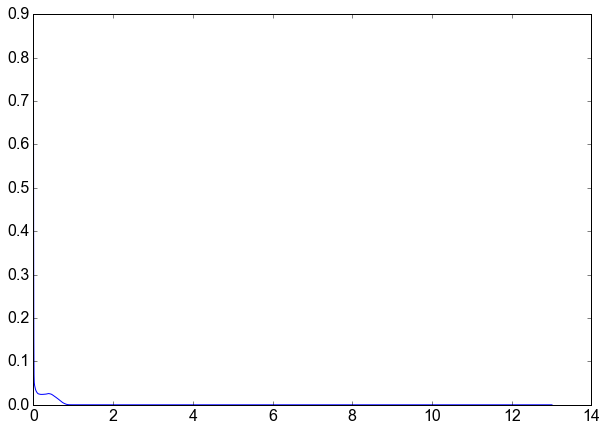

In [68]:
plt.plot(electron_energies, and_response)

### Data to fit and definition $\chi^2$ functions

Here are the spectra that we can fit:

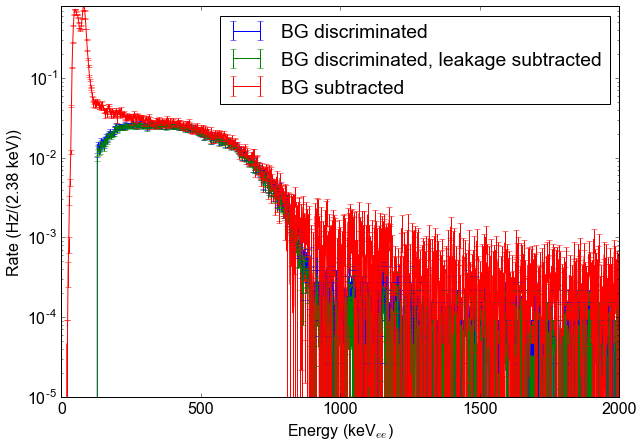

In [5]:
plt.errorbar(e_scale, fg_disc, fg_disc_err, label='BG discriminated')
plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, label='BG discriminated, leakage subtracted')
plt.errorbar(e_scale, fg_sub, fg_sub_err, label= 'BG subtracted')
plt.ylabel('Rate (Hz/(2.38 keV))')

plt.yscale('log')
plt.ylim(0.00001, 0.8)
plt.xlim(0,2000)

# plt.xlim(800,1000)
# plt.ylim(-0.01,0.01)
# plt.axhline(0,color='b')

plt.xlabel('Energy (keV$_{ee}$)')
plt.legend()
plt.show()

In [6]:
from iminuit import Minuit

In [7]:
# Chi^2 function for single Gaussian function in neutron energy
class Chi2Func:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
class Chi2Func_no_err:
    def __init__(self,x,y):
        self.x = x
        self.y_data = y_data

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2)
        return chi2    
    
# Chi^2 function for two Gaussian functions in neutron energy
class Chi2Func_2:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
class Chi2Func_no_err_2:
    def __init__(self,x,y):
        self.x = x
        self.y_data = y_data

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2)
        return chi2    

### Settings for fits

In [225]:
min_e = 500
max_e = 900
use_err = True

### Fit spectrum for BG rejected spectrum

### Fit double Gaussian

In [226]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_disc_sub[sel]
y_err = fg_disc_sub_err[sel]
assert len(fg_disc_sub_err[sel][fg_disc_sub_err[sel] == 0]) == 0

# Initialize chi2 function
if use_err:
    chi2 = Chi2Func_2(x, y_data, y_err)
else:
    chi2 = Chi2Func_no_err_2(x, y_data)

# Give guess parameters
my_args = dict(
    a1=0.15, mu1=2.2, sigma1=0.1, error_a1 = 0.0001, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=0.15, mu2=2.6, sigma2=0.1, error_a2 = 0.0001, error_mu2 = 0.1, error_sigma2 = 0.01,
    errordef=1)
# Initialize minimizer and minimize
m_doub_sub = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m_doub_sub.migrad();
print(m_doub_sub.values)

FCN = 194.83973796002599 
 TOTAL NCALL = 283 
 NCALLS = 283 
 
 
 EDM = 3.259160958747116e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,0.211133,0.040655,0,0,,,
2,mu1,2.3136,0.0309108,0,0,,,
3,sigma1,0.110094,0.0278005,0,0,,,
4,a2,0.0946715,0.0388003,0,0,,,
5,mu2,2.60964,0.0452473,0,0,,,
6,sigma2,0.0775839,0.0293427,0,0,,,


{'a2': 0.09467151533339832, 'sigma2': 0.0775838851456969, 'sigma1': 0.11009362966521433, 'mu2': 2.6096446087719047, 'a1': 0.21113316522237993, 'mu1': 2.3135968854400066}


In [227]:
# THis factor comes from the differnt energy bins. No idea where the 10^4 comes from though...
ad_hoc_factor = (5./2.38)*10**4

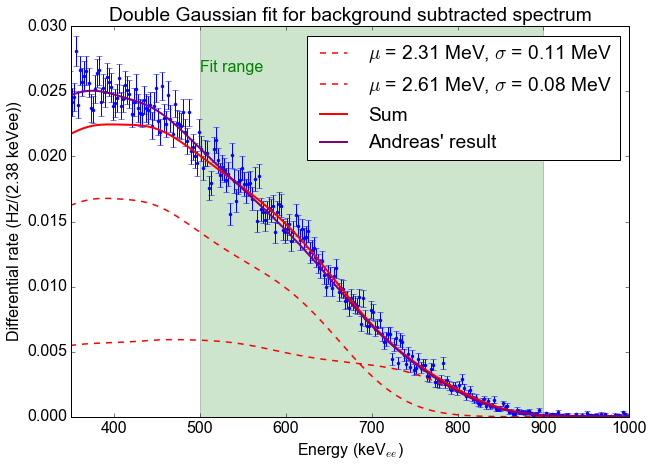

In [228]:
vals = m_doub_sub.values
plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, ls='None', marker='.')
# Take subplots
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a1'], vals['mu1'], vals['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu1'], vals['sigma1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a2'], vals['mu2'], vals['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu2'], vals['sigma2']), ls='--')

plt.plot(e_scale, get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')

# Plot Andreas result
plt.plot(1000*electron_energies, ad_hoc_factor*1/fg_livetime * and_response, color='purple', lw=2, 
         label="Andreas' result")

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.0265, 'Fit range', color='green')

plt.ylim(1e-6,0.3e-1)
plt.xlim(350,1000)
plt.legend()
#plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Double Gaussian fit for background subtracted spectrum')

plt.savefig('plots/fit_spectrum_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

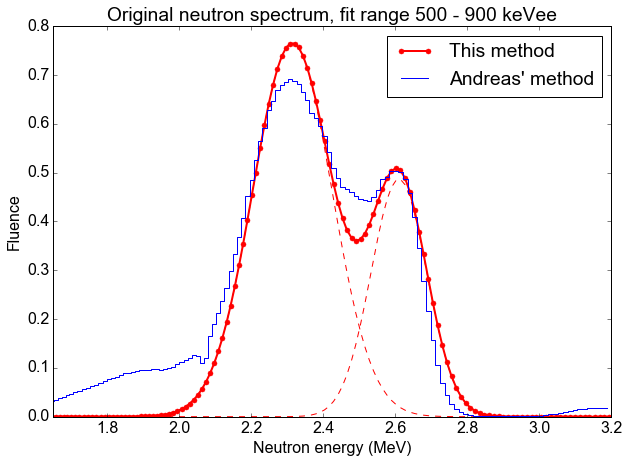

In [229]:
vals = m_doub_sub.values
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']) +
         vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',lw=2,
         marker='.', markersize=10, label='This method')
plt.xlim(1.65, 3.2)
plt.title('Original neutron spectrum, fit range %d - %d keVee' % (min_e, max_e))

plt.plot(e_and, 0.5*y_and, linestyle='steps', label = "Andreas' method")
plt.xlabel('Neutron energy (MeV)')
plt.ylabel('Fluence')
plt.legend()

plt.savefig('plots/neut_spectrum_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

#### Single Gaussian

In [230]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_disc_sub[sel]
y_err = fg_disc_sub_err[sel]
assert len(fg_disc_sub_err[sel][fg_disc_sub_err[sel] == 0]) == 0

# Initialize chi2 function
if use_err:
    chi2 = Chi2Func(x, y_data, y_err)
else:
    chi2 = Chi2Func_no_err(x, y_data)

# Give guess parameters
my_args = dict(
    a=0.3, mu=2.4, sigma=0.196, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)

# m: minimizer; sing: single Gaussian; sub: subtracted the background
m_sing_sub = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_sing_sub.migrad();
print(m_sing_sub.values)

FCN = 220.61710453796204 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 1.0657100979486252e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.31278,0.00324888,0,0,,,
2,mu,2.39479,0.00453244,0,0,,,
3,sigma,0.187713,0.00416342,0,0,,,


{'sigma': 0.18771331739860794, 'mu': 2.3947925618788615, 'a': 0.31277993931682807}


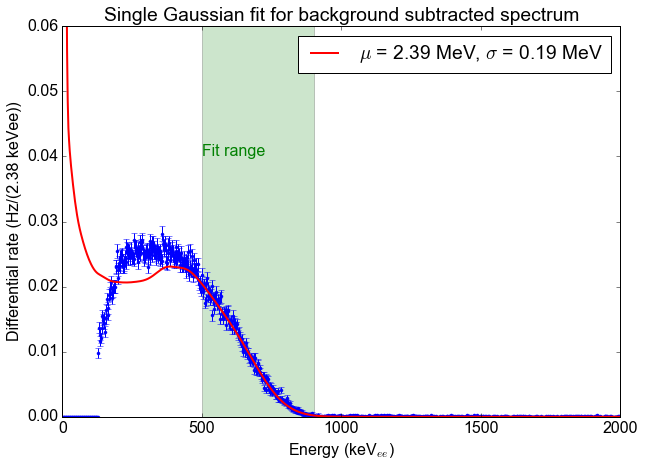

In [231]:
vals = m_sing_sub.values
plt.errorbar(e_scale, fg_disc_sub, fg_disc_sub_err, ls='None', marker='.')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, **vals), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu'], vals['sigma']))

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,0.6e-1)
plt.xlim(0,2000)
plt.legend()
#plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Single Gaussian fit for background subtracted spectrum')
plt.savefig('plots/fit_spectrum_sub_sing_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

### High energy population, rebinning method

This is probably the better method to use (other depricated as of July 29, 2016). It is based on the 99 percentile of BG in 50 bins. With this we extend the energy range a lot, all the way down to:

#### Settings

In [206]:
min_e_he  = 2000
max_e_he  = np.inf
# For motivation: see end of this note
min_e_led = 6670
max_e_led = 7980

In [207]:
from scipy.integrate import quad

In [208]:
def integrand(x):
    return 50*get_neutron_spectrum_interpolated_2(x, **vals)


In [209]:
# Quick and dirty integration but stilll within % level of scipy.integrate.quad (which is super expensive)
# And: note that it's a correction anyway...
to_sub = []
npoints = 100
for e in e_scale_he:
    e_to_eval = np.linspace(e - 25, e+25, npoints)
    to_sub.append(np.average(integrand(e_to_eval)))
to_sub = np.array(to_sub)

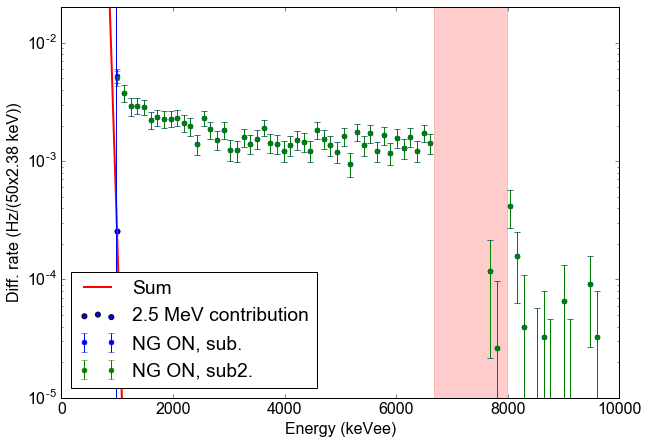

In [210]:
plt.errorbar(e_scale_he,fg_he_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub.')
plt.errorbar(e_scale_he,fg_he_sub-to_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub2.')

plt.plot(e_scale, 50*get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')
plt.scatter(e_scale_he,to_sub, marker='.', s=100, label='2.5 MeV contribution')
draw_box((min_e_led,max_e_led),(0,1), color='red', alpha=0.2)
plt.axvline(min(e_scale_he)-25)
plt.ylim(0.00001,0.02)
plt.xlim(0,10000)
plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Diff. rate (Hz/(50x2.38 keV))')
plt.legend(loc='lower left')
plt.show()

In [211]:
mask = ((e_scale_he <min_e_led) | (e_scale_he > max_e_led)) & (e_scale_he > min_e_he) & (e_scale_he < max_e_he)
x = e_scale_he[mask]

y_data = fg_he_sub[mask] - to_sub[mask]
y_err = fg_he_sub_err
# Set errors to one if entry is zero
for i, ye in enumerate(y_err):
    if ye==0:
        y_err[i] = 1/(ng_livetimes[0]+ng_livetimes[1])*1.
        print("WARNING zero entries at %.1f keV" % e_scale_he[i])
y_err = y_err[mask]

(2000.0, 10000.0)

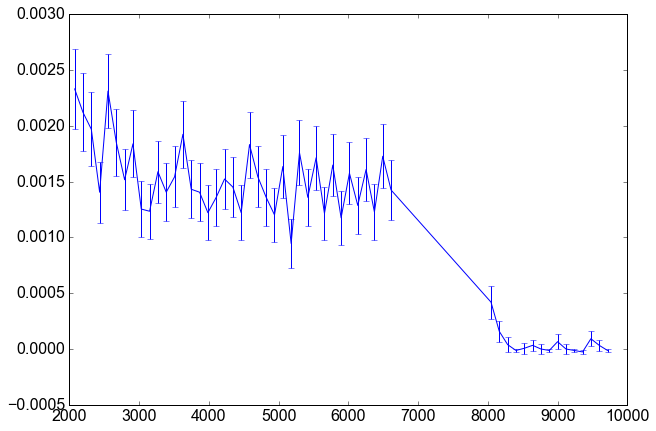

In [212]:
plt.errorbar(x,y_data,y_err)
plt.xlim()

In [213]:
chi2 = Chi2Func(x, y_data, y_err)

In [214]:
# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a=0.4, mu=14, sigma=0.01, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)
# Initialize minimizer and minimize
m_high_2 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_high_2.migrad();
print(m_high_2.values)

FCN = 51.054535859007274 
 TOTAL NCALL = 77 
 NCALLS = 77 
 
 
 EDM = 3.8703723945896355e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.400015,0.831025,0,0,,,
2,mu,13.9988,0.0126524,0,0,,,
3,sigma,0.00594977,0.0126953,0,0,,,


{'sigma': 0.0059497720696940985, 'mu': 13.998834790770294, 'a': 0.40001473094505374}


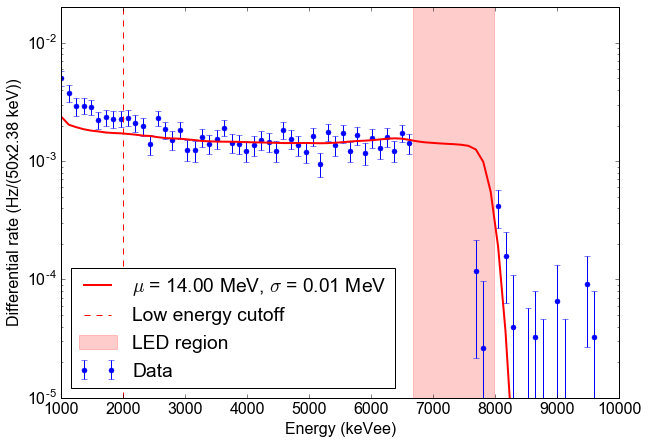

In [235]:
plt.errorbar(e_scale_he,fg_he_sub-to_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='Data')
plt.plot(e_scale_he,get_neutron_spectrum_interpolated(e_scale_he, **m_high_2.values), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (m_high_2.values['mu'],m_high_2.values['sigma']))

draw_box((min_e_led,max_e_led),(0,1), color='red', alpha=0.2, label='LED region')
plt.axvline(min_e_he, ls='--', color='red', label='Low energy cutoff')
plt.ylim(0.00001,0.02)
plt.xlim(1000,10000)
plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Differential rate (Hz/(50x2.38 keV))')
plt.legend(loc='lower left')

plt.savefig('./plots/he_spec.png', bbox_inches='tight')
plt.show()

### Combine EVERYTHING

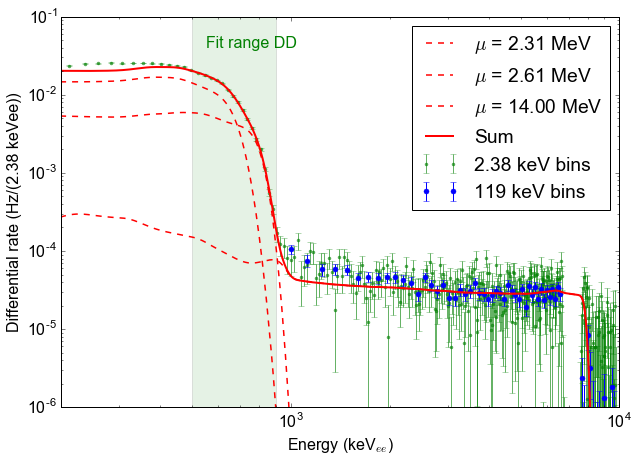

In [238]:
rebin_fac = 10

vals1 = m_doub_sub.values
vals2 = m_high_2.values

# Data (rebinned)
plt.errorbar(rebin(e_scale,rebin_fac), rebin(fg_disc_sub,rebin_fac), rebin(fg_disc_sub_err,rebin_fac, mode='quad_avg'),
             ls='None', marker='.', label='2.38 keV bins', color='green', alpha=0.6)
# High energy data
plt.errorbar(e_scale_he, 0.02*fg_he_sub, 0.02*fg_he_sub_err, ls='None', marker='.', 
             markersize = 10, label='119 keV bins', color='blue')

# Subplots (3 contributions)
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a1'], vals1['mu1'], vals1['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV' % (vals1['mu1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a2'], vals1['mu2'], vals1['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV' % (vals1['mu2']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, 0.02*vals2['a'], vals2['mu'], vals2['sigma']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV' % (vals2['mu']), ls='--')

# Full fit
plt.plot(e_scale, get_neutron_spectrum_interpolated_3(e_scale,
                                                     vals1['a1'], vals1['mu1'], vals1['sigma1'],
                                                     vals1['a2'], vals1['mu2'], vals1['sigma2'],
                                                     0.02*vals2['a'], vals2['mu'], vals2['sigma'], 
                                                     ), color='red', lw=2,
        label='Sum')

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.1)
plt.text(550, 0.04, 'Fit range DD', color='green')

plt.ylim(1e-6,1e-1)
#plt.xlim(0,9000)
plt.xscale('log')
plt.xlim(200.,1e4)
#plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
#plt.title('Double Gaussian fit for background subtracted spectrum')
plt.legend()

plt.savefig('./plots/all_combined.png', bbox_inches='tight')
plt.show()

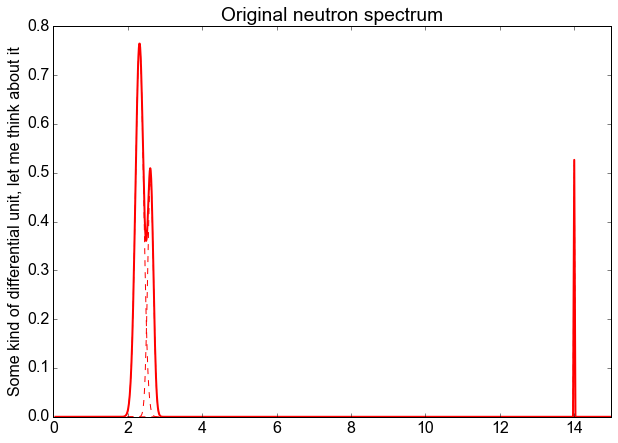

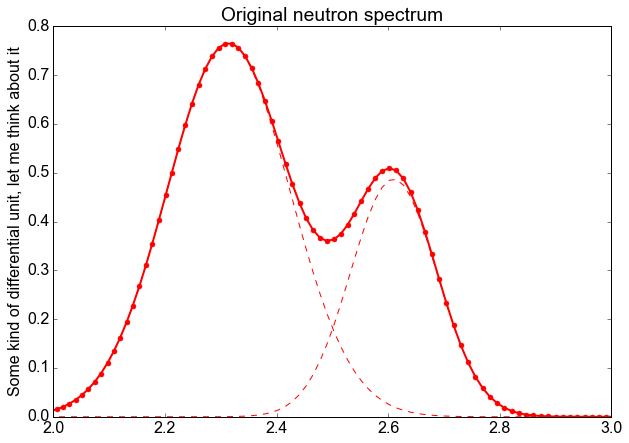

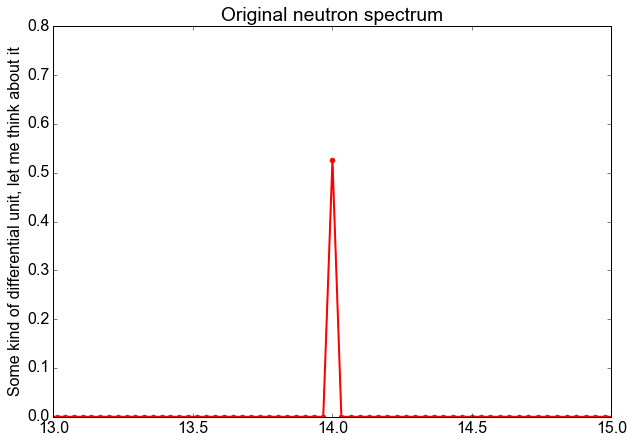

In [239]:
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2)
plt.xlim(0, 15)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2, marker='.', markersize=10)
plt.xlim(2, 3)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2, marker='.', markersize=10)
plt.xlim(13, 15)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

In [25]:
def int_spec(x, y):
    '''
    Integrate spectrum
    '''
    dx = np.diff(x)
    return sum(y[:-1]*dx)

In [26]:
int_gauss1 = int_spec(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']))
int_gauss2 = int_spec(neutron_energies,vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']))
int_gauss3 = int_spec(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']))
int_tot = int_gauss1 + int_gauss2 + int_gauss3

In [240]:
print('Totals: %.1f%% at %.2f MeV; %.1f%% at %.2f MeV; %.1f%% at %.2f MeV' % 
      (int_gauss1/int_tot*100, vals1['mu1'],
      int_gauss2/int_tot*100, vals1['mu2'],
       int_gauss3/int_tot*100, vals2['mu'],
      ))

Totals: 49.9% at 2.31 MeV; 44.9% at 2.61 MeV; 5.2% at 14.00 MeV


### Random scraps

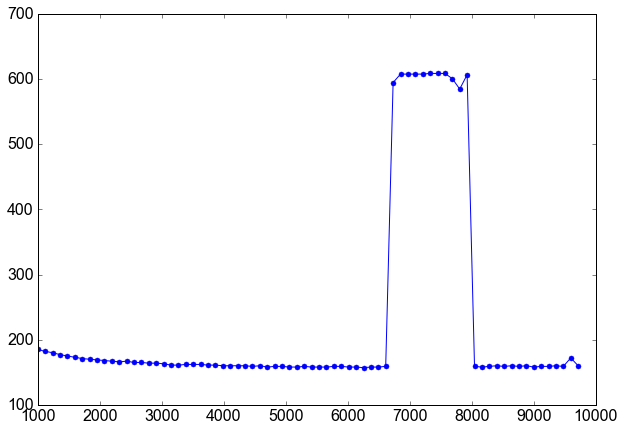

In [200]:
plt.plot(e_scale_he, cutoffs, marker='.', markersize=10)

In [203]:
led_region = e_scale_he[np.array(cutoffs) > 400]

In [205]:
# left bound
print(led_region[0] - 0.5*2.38*50)
print(led_region[-1] + 0.5*2.38*50)

6670.8625
7983.6125
